In [ ]:
import os
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(os.listdir("/content/drive/MyDrive"))

['LSWMD.pkl', '차세대반도체 포항공대 학점교류 지원 신청서.pdf', 'Colab Notebooks', 'Screenshot_20231007_122944_Chrome.jpg', 'Screenshot_20231007_123214_Chrome.jpg', '인공지능반도체 장학금 증빙서류.pdf', '각 파일 설명.txt']


# 데이터 가져오기

In [ ]:
df=pd.read_pickle("/content/drive/MyDrive/LSWMD.pkl") #data load

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [ ]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [ ]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


In [ ]:
df.lotName

0             lot1
1             lot1
2             lot1
3             lot1
4             lot1
            ...   
811452    lot47542
811453    lot47542
811454    lot47542
811455    lot47543
811456    lot47543
Name: lotName, Length: 811457, dtype: object

In [ ]:
df.keys()

Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType'],
      dtype='object')

In [ ]:
df.failureType[:]

0              [[none]]
1              [[none]]
2              [[none]]
3              [[none]]
4              [[none]]
              ...      
811452    [[Edge-Ring]]
811453     [[Edge-Loc]]
811454    [[Edge-Ring]]
811455               []
811456               []
Name: failureType, Length: 811457, dtype: object

failureType labeling 되지 않은 데이터 존재 확인 --> 이후 제거하여 사용하기로 한다.

train, test 는 이미 나눠져있는 것으로 확인 --> 이후 학습시 그대로 이용해서 사용하기로 한다.

In [ ]:
# wafer 차원 column 추가
def find_dim(x):
    dim0=np.size(x, axis=0)
    dim1=np.size(x, axis=1)
    return dim0, dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
690731,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1129.0,lot42649,9.0,[[Test]],[[none]],"(39, 37)"
684544,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1192.0,lot42394,17.0,[[Test]],[[none]],"(38, 40)"
683633,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",845.0,lot42357,6.0,[[Test]],[[none]],"(35, 31)"
167788,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",572.0,lot10688,20.0,[],[],"(22, 35)"
422177,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3014.0,lot25340,25.0,[],[],"(64, 60)"


In [ ]:
#최대, 최소 차원 출력
max(df['waferMapDim']),min(df['waferMapDim'])

((300, 202), (6, 21))

다양한 차원 가지는 것 알 수 있음 --> 이후 단일 차원만 골라서 사용하기로 한다.

# 데이터 준비하기

labeling 된것들만 빼기 쉽게 하기 위해 failurType에 숫자 부여 --> failurNum column 추가

In [ ]:
#라벨링 숫자로 바꿔주기 failureType --> failurNum
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5,'Scratch':6, 'Near-full':7, 'none':8}
mapping_traintest={'Training':0, 'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [ ]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)] # label 달려있는 것들로만새로운 데이터 프레임 생성
df_withlabel = df_withlabel.reset_index() # 인덱스 새롭게설정
df_withlabel

,index,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],"(45, 48)",8,0
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],"(45, 48)",8,0
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],"(45, 48)",8,0
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],"(45, 48)",8,0
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],"(45, 48)",8,0
...,...,...,...,...,...,...,...,...,...,...
172945,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1
172946,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1
172947,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]],"(26, 30)",3,1
172948,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1


In [ ]:
df_without_none = df[(df['failureNum']>=0) & (df['failureNum']<=7)] # 레이블중 none 제외
df_without_none = df_without_none.reset_index()
df_without_none

,index,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],[[Loc]],"(45, 48)",4,0
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0
...,...,...,...,...,...,...,...,...,...,...
25514,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1
25515,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1
25516,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]],"(26, 30)",3,1
25517,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1


In [ ]:
df_none = df[(df['failureNum']==8)] # 레이블 = none 만 포함
df_withlabel.shape[0], df_without_none.shape[0], df_none.shape[0] # 각 데이터 프레임 행 갯수 반환(label있는거 전체, none제외, none만 포함)

(172950, 25519, 147431)

label이 된 데이터중 failure type이 none인 것(정상이라고 판단되는 것)이 대다수 인것 확인

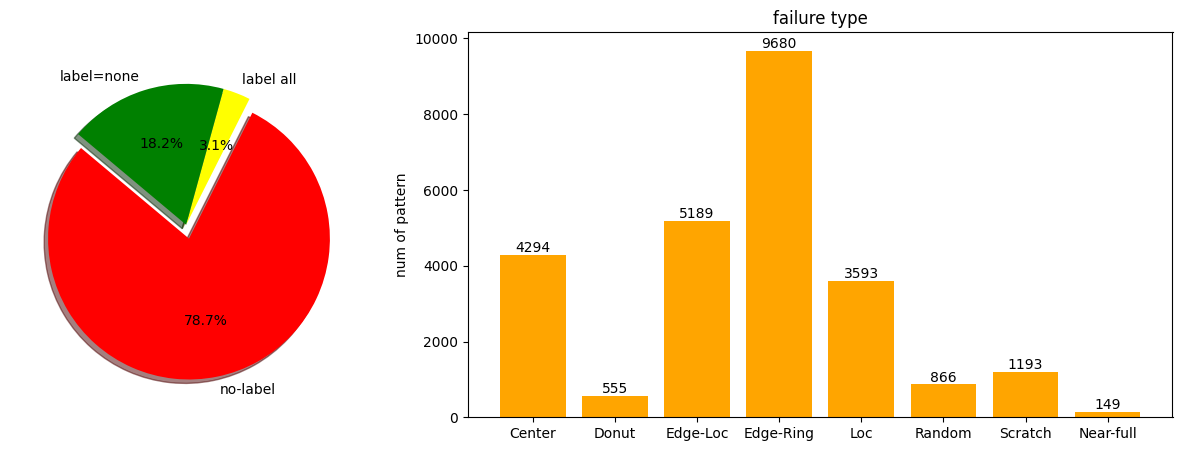

In [ ]:
#label 유무에 따라
#label 있는 것들 중 failure type에 따라
#failure type 중 none 제외후, 종류에 따라
#나누고 시각화해서 비율 및 개수 보기
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
figure = plt.figure(figsize=(15,5))
gridspec = gridspec.GridSpec(1, 2, width_ratios=[1,2])
ax1 = plt.subplot(gridspec[0])
ax2 = plt.subplot(gridspec[1])

no_wafers=[df.shape[0]-df_withlabel.shape[0], df_without_none.shape[0], df_none.shape[0]]

colors = ['red', 'yellow', 'green']
explode = (0.1, 0, 0)
labels = ['no-label', 'label all', 'label=none']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_without_none.failureNum, return_counts=True)
labels2=['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
bars=ax2.bar(uni_pattern[0],uni_pattern[1], color='orange', align='center', alpha=1)
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval, 1), ha='center', va='bottom')
ax2.set_title("failure type")
ax2.set_ylabel("num of pattern")
ax2.set_xticklabels(labels2)

plt.show()

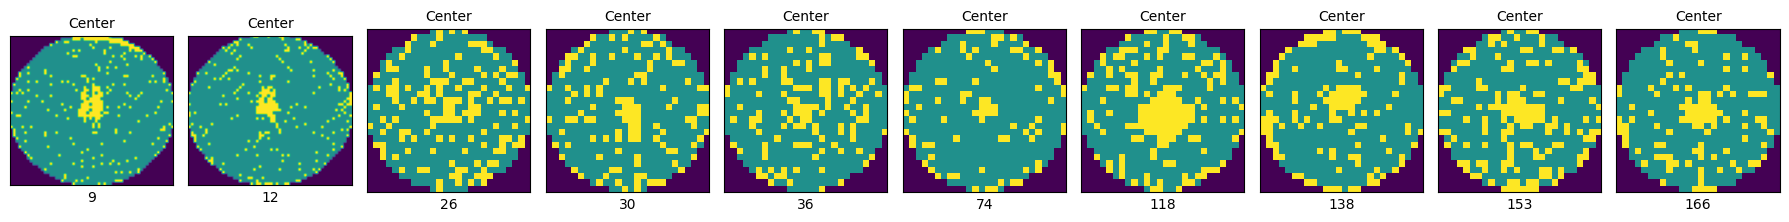

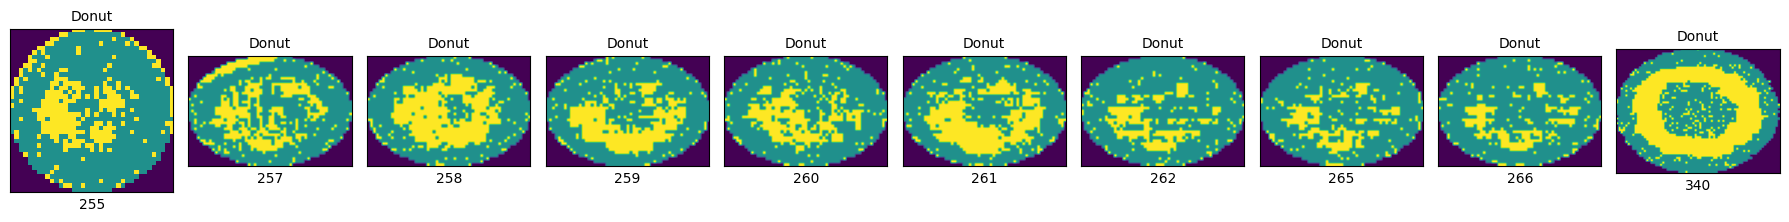

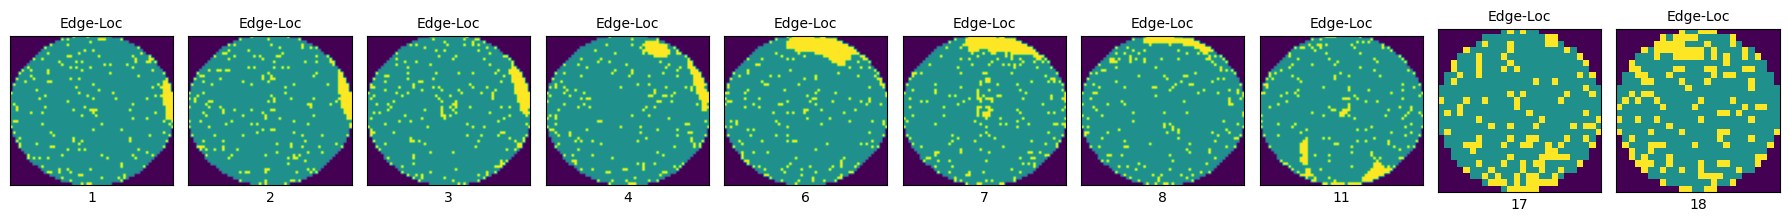

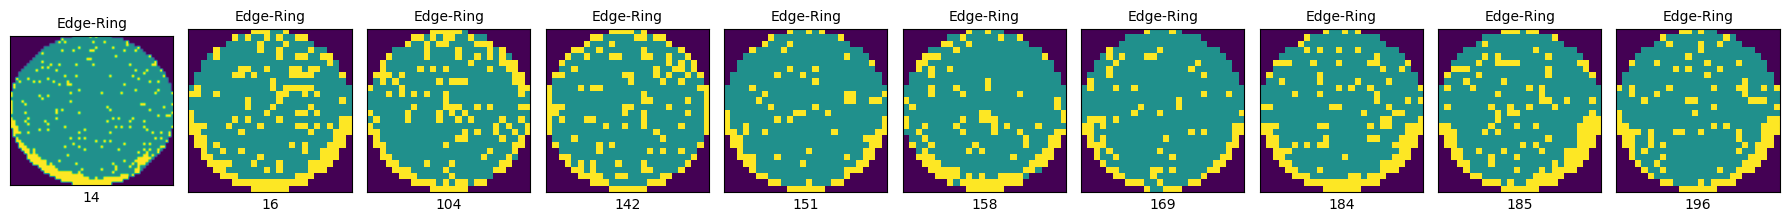

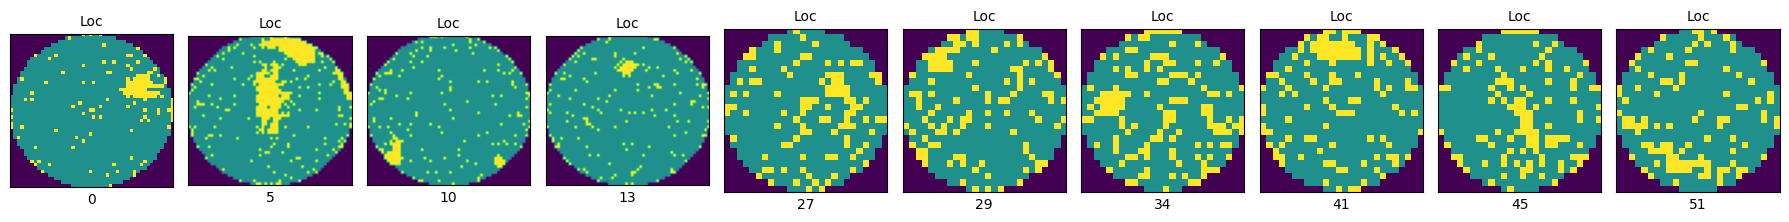

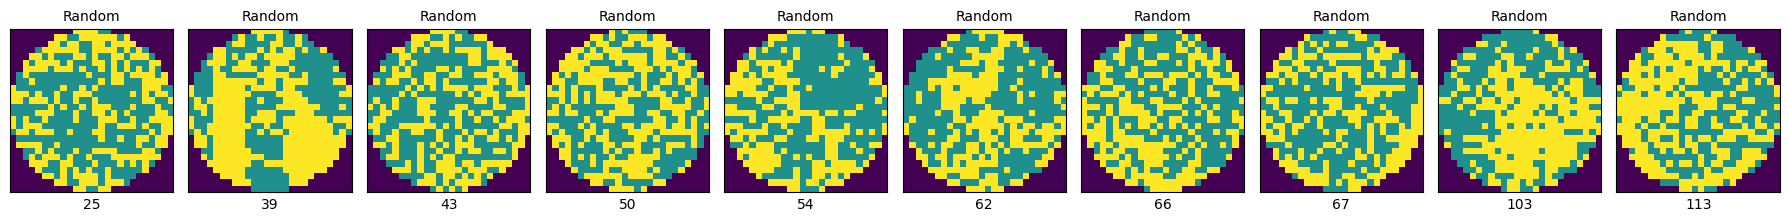

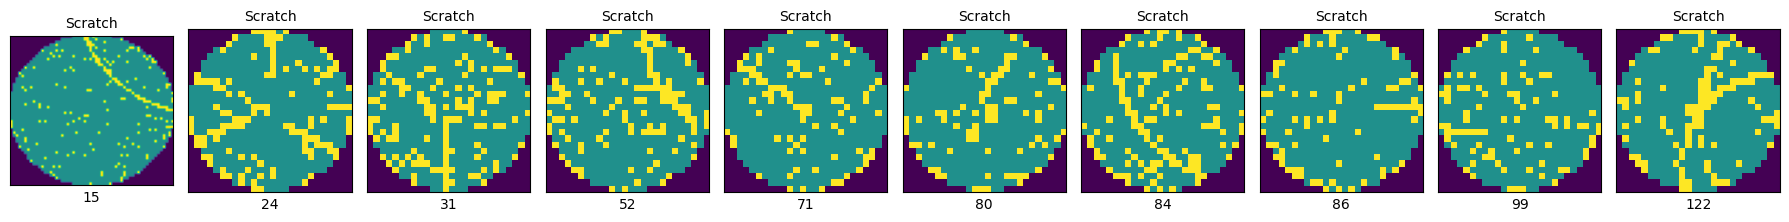

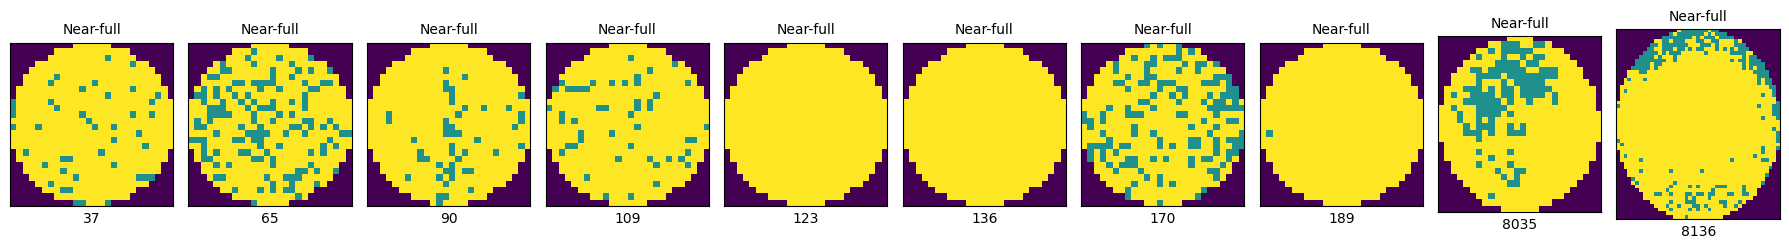

In [ ]:
#none 제외 각 failurtype에 해당하는 데이터 이미지 시각화
x=[0,1,2,3,4,5,6,7]
labels2=['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for i in x:
    fig, ax=plt.subplots(nrows=1, ncols=10, figsize=(18,12))
    ax=ax.ravel(order='C') # ravel은 다차원 배열을 1차원으로 변경, C는 기본값
    for j in [i]:
        img=df_without_none.waferMap[df_without_none.failureType==labels2[j]]
        for k in range(10):
            ax[k].imshow(img[img.index[k]])
            ax[k].set_title(df_without_none.failureType[img.index[k]][0][0], fontsize=10)
            ax[k].set_xlabel(df_without_none.index[img.index[k]], fontsize=10)
            ax[k].set_xticks([])
            ax[k].set_yticks([])
    plt.tight_layout()
    plt.show()

데이터 이미지를 보면 직사각형 안에 wafer에 해당하는 원모양 속에 normal(정상)에 해당하는 청록색, defect(불량)에 해당하는 노란색으로 이루어진거 확인

실제로 학습에 데이터 선정 위해 wafer dimension 기준으로 가장 많은 것 선택

In [ ]:
import pandas as pd


# 'waferMapdim' 열 값에 따라 개수를 세기
class_counts = df_withlabel['waferMapDim'].value_counts()


# 가장 개수가 많은 5개의 클래스 확인
top_5_classes = class_counts.head(5)

print("가장 개수가 많은 5개의 wafer dimension:")
print(top_5_classes)


가장 개수가 많은 5개의 wafer dimension:
(25, 27)    18781
(26, 26)    14366
(30, 34)    12400
(29, 26)    11751
(27, 25)    10682
Name: waferMapDim, dtype: int64


(25,27) dimension으로 선택

In [ ]:
df_select = df_withlabel[(df_withlabel['waferMapDim']==(25,27))]
df_select = df_select.reset_index()
df_select

,level_0,index,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,7100,16409,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1,...",515.0,lot2282,14.0,[[Training]],[[Edge-Loc]],"(25, 27)",2,0
1,7101,16432,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1,...",515.0,lot2283,14.0,[[Training]],[[Edge-Loc]],"(25, 27)",2,0
2,7102,16455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1,...",515.0,lot2284,14.0,[[Training]],[[Edge-Loc]],"(25, 27)",2,0
3,8201,22785,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,...",515.0,lot2608,2.0,[[Training]],[[Edge-Loc]],"(25, 27)",2,0
4,8202,22787,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,...",515.0,lot2610,19.0,[[Training]],[[Edge-Loc]],"(25, 27)",2,0
...,...,...,...,...,...,...,...,...,...,...,...
18776,81884,714199,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot43595,21.0,[[Test]],[[none]],"(25, 27)",8,1
18777,81885,714200,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot43595,22.0,[[Test]],[[none]],"(25, 27)",8,1
18778,81886,714201,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot43595,23.0,[[Test]],[[Edge-Loc]],"(25, 27)",2,1
18779,81887,714202,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",516.0,lot43595,24.0,[[Test]],[[none]],"(25, 27)",8,1


In [ ]:
unique_classes,counts =np.unique(df_select.failureType, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"failureType  {cls}: {count} samples")

failureType  [['Center']]: 2251 samples
failureType  [['Edge-Loc']]: 355 samples
failureType  [['Edge-Ring']]: 25 samples
failureType  [['Loc']]: 172 samples
failureType  [['Near-full']]: 21 samples
failureType  [['Random']]: 53 samples
failureType  [['Scratch']]: 23 samples
failureType  [['none']]: 15881 samples


class 가 8개밖에없다('Donut' type에 해당하는 데이터 x).

다음으로 많은 dimension (26,26) 확인

In [ ]:
df_select = df_withlabel[(df_withlabel['waferMapDim']==(26,26))]
df_select = df_select.reset_index()
df_select

,level_0,index,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,146,150,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,1.0,[[Training]],[[none]],"(26, 26)",8,0
1,147,151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,2.0,[[Training]],[[none]],"(26, 26)",8,0
2,148,152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,3.0,[[Training]],[[none]],"(26, 26)",8,0
3,149,153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,4.0,[[Training]],[[none]],"(26, 26)",8,0
4,150,154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,5.0,[[Training]],[[none]],"(26, 26)",8,0
...,...,...,...,...,...,...,...,...,...,...,...
14361,49823,679251,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot42179,21.0,[[Test]],[[none]],"(26, 26)",8,1
14362,49824,679252,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot42179,22.0,[[Test]],[[none]],"(26, 26)",8,1
14363,49825,679253,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",533.0,lot42179,23.0,[[Test]],[[none]],"(26, 26)",8,1
14364,49826,679254,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",533.0,lot42179,24.0,[[Test]],[[none]],"(26, 26)",8,1


In [ ]:
unique_classes,counts =np.unique(df_select.failureType, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"failureType  {cls}: {count} samples")

failureType  [['Center']]: 90 samples
failureType  [['Donut']]: 1 samples
failureType  [['Edge-Loc']]: 296 samples
failureType  [['Edge-Ring']]: 31 samples
failureType  [['Loc']]: 297 samples
failureType  [['Near-full']]: 16 samples
failureType  [['Random']]: 74 samples
failureType  [['Scratch']]: 72 samples
failureType  [['none']]: 13489 samples


class 9개 전부 존재, 따라서 dimension은 26,26으로 사용

In [ ]:
#train , test data 개수 표시
unique_classes,counts =np.unique(df_select.trainTestNum, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"trainTestNum  {cls}: {count} samples")

trainTestNum  0: 6369 samples
trainTestNum  1: 7997 samples


In [ ]:
df_train = df_select[(df_select.trainTestNum==0)]
df_test = df_select[(df_select.trainTestNum==1)]

df_train.shape ,df_test.shape


((6369, 11), (7997, 11))

In [ ]:
unique_classes,counts =np.unique(df_train.failureType, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"{cls}: {count} samples")

[['Center']]: 28 samples
[['Edge-Loc']]: 131 samples
[['Edge-Ring']]: 19 samples
[['Loc']]: 58 samples
[['Near-full']]: 8 samples
[['Random']]: 31 samples
[['Scratch']]: 21 samples
[['none']]: 6073 samples


train data 개수 부족 하다 -->data를 증강해서 사용한다.   
class 8개 밖에 없다(Donut type 데이터 x) --> 다른 dimension 데이터에서 불러와서 resize해서 사용한다.

다른 dimension 데이터에서 불러올때는 (26,26)의 정사각형 모양으로 맞춰야 하므로  
비율을 같이하여 이미지 깨짐을 방지하기 위해 정사각형 dimension에 해당하는 Donut type데이터 가져와서 사용한다.

In [ ]:
#다른 dimension에서 donut 데이터만 추출
df_donut = df_withlabel[(df_withlabel['failureNum']==1)]
df_donut = df_donut[(df_withlabel['waferMapDim'].apply(lambda x: x[0]) == df_withlabel['waferMapDim'].apply(lambda x: x[1]))]

df_donut = df_donut.reset_index()

unique_classes,counts =np.unique(df_donut.waferMapDim, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"failureType  {cls}: {count} samples")

failureType  (26, 26): 1 samples
failureType  (30, 30): 3 samples
failureType  (31, 31): 2 samples
failureType  (33, 33): 2 samples
failureType  (37, 37): 1 samples
failureType  (38, 38): 1 samples
failureType  (40, 40): 2 samples
failureType  (44, 44): 1 samples
failureType  (72, 72): 1 samples


In [ ]:
X_donut, y_donut= np.array(df_donut['waferMap'].values.tolist()), np.array(df_donut["failureNum"])


In [ ]:
from PIL import Image

img=Image.fromarray(X_donut[0])

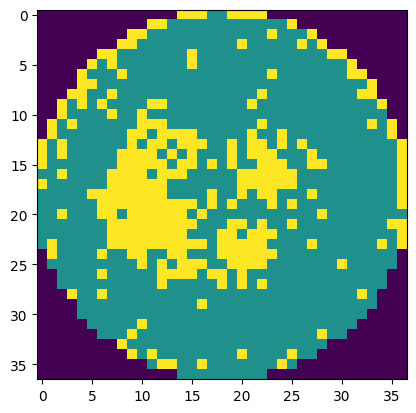

In [ ]:
#예시 1개 이미지 확인
plt.imshow(X_donut[0])

In [ ]:
#이미지 1개에 대해여 resize 해보기
from PIL import Image

# 원본 이미지 크기 확인
original_width, original_height = img.size
print("원본 이미지 크기:", original_width, "x", original_height)

# 축소할 크기
target_width, target_height = 26, 26

# 이미지 비율 계산
aspect_ratio = original_width / original_height

# 새로운 높이 계산
new_height = int(target_width / aspect_ratio)

# 이미지 크기 조절
resized_image = img.resize((target_width, new_height), Image.ANTIALIAS)

# 결과 이미지 크기 확인
resized_width, resized_height = resized_image.size
print("조절된 이미지 크기:", resized_width, "x", resized_height)




원본 이미지 크기: 37 x 37
조절된 이미지 크기: 26 x 26


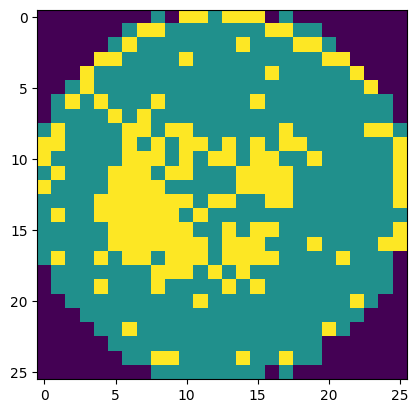

In [ ]:
plt.imshow(resized_image)

In [ ]:
#위에서 뽑은 모든 donut이미지에 대해여 resize 해보기

X_donut_new=[]
for idx, image in enumerate(X_donut):
  img=Image.fromarray(image)
  original_width, original_height = img.size

  target_width, target_height = 26, 26

  aspect_ratio = original_width / original_height

  # 새로운 높이 계산
  new_height = int(target_width / aspect_ratio)

  # 이미지 크기 조절
  resized_image = img.resize((target_width, new_height), Image.ANTIALIAS)
  X_donut_new.append(np.array(resized_image))

X_donut=np.array(X_donut_new)
X_donut.shape


(14, 26, 26)

In [ ]:
X_train, y_train= np.array(df_train['waferMap'].values.tolist()), np.array(df_train["failureNum"])

X_test, y_test= np.array(df_test['waferMap'].values.tolist()), np.array(df_test["failureNum"])


In [ ]:
#donut 데이터 추가전
X_train.shape, y_train.shape , X_test.shape, y_test.shape

((6369, 26, 26), (6369,), (7997, 26, 26), (7997,))

In [ ]:
#donut 데이터 추가
X_train = np.concatenate((X_train,X_donut),axis =0)
y_train = np.concatenate((y_train, y_donut),axis =0)

In [ ]:
#donut 데이터 추가 후
X_train.shape, y_train.shape

((6383, 26, 26), (6383,))

In [ ]:
unique_classes,counts =np.unique(y_train, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"{cls}: {count} samples")

0: 28 samples
1: 14 samples
2: 131 samples
3: 19 samples
4: 58 samples
5: 31 samples
6: 21 samples
7: 8 samples
8: 6073 samples


dount 데이터 잘 추가 된것 확인

In [ ]:
X_train[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2,
        0, 0, 0, 0],
       [0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
        2, 0, 0, 0],
       [0, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 2, 0, 0],
       [0, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0],
       [0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
        1, 1, 1, 0],
       [0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 2, 0],
       [1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1],
       [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 

픽셀 값 0(wafer 아닌 곳), 1(normal : 정상), 2(defect)픽셀로 이루어진 것 확인  
나중에 CNN모델에 넣기위해 각 픽셀값의 종류에 따라 채널을 3개로 만들어준다 -->onehot encoding

In [ ]:
#0,1,2로 one-hot-encoding
from tensorflow.keras.utils import to_categorical

X_train = to_categorical(X_train, num_classes=3)
X_test = to_categorical(X_test, num_classes=3)

In [ ]:
#shape 변경 확인
X_train.shape, X_test.shape

((6383, 26, 26, 3), (7997, 26, 26, 3))

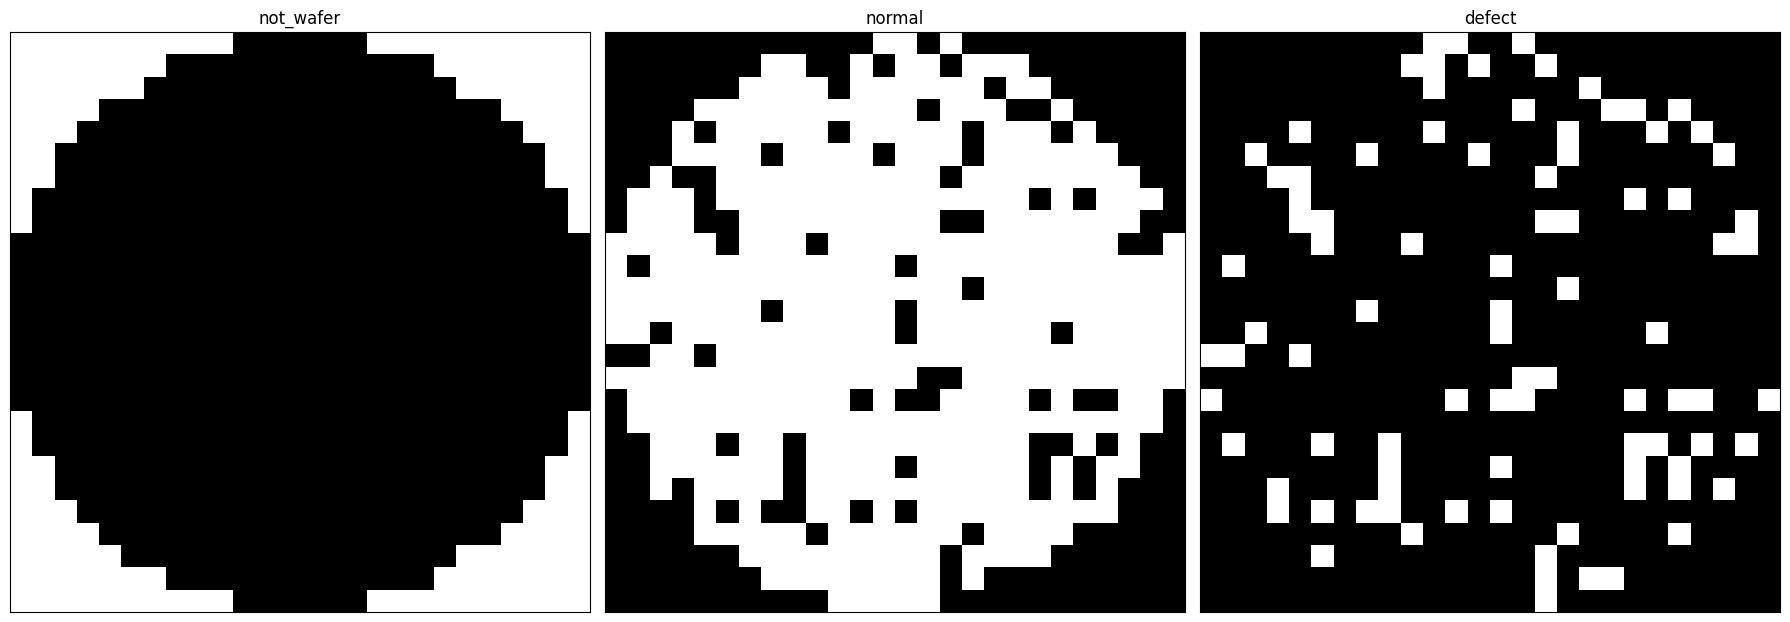

In [ ]:
#0,1,2로 one-hot-encoding 잘 됬는지 확인

fig, ax=plt.subplots(nrows=1, ncols=3, figsize=(18,12))

ax=ax.ravel(order='C') # ravel은 다차원 배열을 1차원으로 변경, C는 기본값

ax[0].imshow(X_train[0, :, :, 0],cmap='gray')
ax[0].set_title("not_wafer")
ax[0].set_xticks([])
ax[0].set_yticks([])


ax[1].imshow(X_train[0, :, :, 1],cmap='gray')
ax[1].set_title("normal")
ax[1].set_xticks([])
ax[1].set_yticks([])


ax[2].imshow(X_train[0, :, :, 2],cmap='gray')
ax[2].set_title("defect")
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array
import matplotlib.pyplot as plt

# 이미지 데이터 증강을 위한 ImageDataGenerator 생성
data_gen = ImageDataGenerator(vertical_flip=True,horizontal_flip=True,rotation_range=10,)

# 특정 레이블의 이미지만 선택
#label_to_augment = "1"


label_1_indices = np.where(y_train == 0)[0]
X_train_label = X_train[label_1_indices]

# 특정 레이블에 해당하는 이미지 데이터
#X_train_label = ...

# 증강된 이미지를 담을 리스트
augmented_images = []

# 특정 레이블에 대한 이미지 데이터를 가져와서 증강
for img_array in X_train_label:
    img_array = img_array.reshape((1,) + img_array.shape)  # 모델이 받아들일 수 있는 형태로 변환

    # flow 메서드를 사용하여 이미지 증강 수행
    augmented_data = data_gen.flow(img_array, batch_size=1)

    # 증강된 이미지를 리스트에 추가
    augmented_images.extend([next(augmented_data)[0] for _ in range(5)])  # 5번 증강 예시

new=np.array(augmented_images)



In [ ]:
new.shape

(140, 26, 26, 3)

train data는 증강하여 class개수를 맞춰서 사용한다.   
-->맞추는 기준은 가장 많은 none type인 6000개 기준으로  

test data는 따로 증강안하고 주어져 있는 데이터 그대로 사용한다.

In [ ]:
# 이미지 데이터 증강을 위한 ImageDataGenerator 생성
from keras.preprocessing.image import ImageDataGenerator, img_to_array
#증강은 flip과 rotation만 활용
data_gen = ImageDataGenerator(vertical_flip=True,horizontal_flip=True,rotation_range=10,)


for i in range(8):
  # 특정 label에 해당하는 index
  label_indices = np.where(y_train == i)[0]

  # index에 해당하는 이미지 데이터
  X_train_label = X_train[label_indices]

  #추가할 개수 : 가장많은 none 데이터인 6000개 기준으로 그거와 맞게 증강
  time=int((6000/len(label_indices)))-1


# 증강된 이미지를 담을 리스트
  augmented_images = []

# 특정 레이블에 대한 이미지 데이터를 가져와서 증강
  for img_array in X_train_label:
      img_array = img_array.reshape((1,) + img_array.shape)  # 모델이 받아들일 수 있는 형태로 변환

    # flow 메서드를 사용하여 이미지 증강 수행
      augmented_data = data_gen.flow(img_array, batch_size=1)

    # 증강된 이미지를 리스트에 추가
      augmented_images.extend([next(augmented_data)[0] for _ in range(time)])




  X_train_new=np.array(augmented_images)

  #새로만든 X_train_new의 개수에 맞게 추가 label 생성
  y_train_new = np.full((X_train_new.shape[0],), i)

  #원래 데이터와 합치기
  X_train= np.concatenate((X_train,X_train_new),axis =0)
  y_train = np.concatenate((y_train, y_train_new),axis =0)



In [ ]:
X_train.shape ,y_train.shape

((53879, 26, 26, 3), (53879,))

In [ ]:
unique_classes,counts =np.unique(y_train, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"{cls}: {count} samples")

0: 5992 samples
1: 5992 samples
2: 5895 samples
3: 5985 samples
4: 5974 samples
5: 5983 samples
6: 5985 samples
7: 6000 samples
8: 6073 samples


모든 class의 개수 균일하게 증강된것 확인

In [ ]:
#data shuffling
indices = np.arange(len(X_train))
np.random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

indices = np.arange(len(X_test))
np.random.shuffle(indices)
X_test = X_test[indices]
y_test = y_test[indices]


In [ ]:
#array --> tensor
X_train = tf.convert_to_tensor(X_train,dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train,dtype=tf.float32)

X_test = tf.convert_to_tensor(X_test,dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test,dtype=tf.float32)

# 모델 구성, 학습 및 최적화

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 클래스 개수
num_classes = 9

# 모델 정의
model = models.Sequential()

# 첫 번째 합성곱 층
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(26, 26, 3)))

# 두 번째 합성곱 층
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((1, 1)))

# 세 번째 합성곱 층
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(192, (3, 3), activation='relu', padding='same'))

# 완전 연결 층
model.add(layers.Flatten())
model.add(layers.Dense(192, activation='relu'))

# 출력 층
model.add(layers.Dense(num_classes, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 구조 출력
model.summary()





Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 conv2d_17 (Conv2D)          (None, 26, 26, 64)        9280      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 13, 13, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 192)      

In [ ]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=160, validation_split=0.2)

Epoch 1/20
270/270 [==============================] - 11s 35ms/step - loss: 0.2178 - accuracy: 0.9211 - val_loss: 0.0165 - val_accuracy: 0.9947
Epoch 2/20
270/270 [==============================] - 8s 31ms/step - loss: 0.0236 - accuracy: 0.9921 - val_loss: 0.0128 - val_accuracy: 0.9959
Epoch 3/20
270/270 [==============================] - 9s 35ms/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 0.0072 - val_accuracy: 0.9976
Epoch 4/20
270/270 [==============================] - 8s 31ms/step - loss: 0.0431 - accuracy: 0.9901 - val_loss: 0.0082 - val_accuracy: 0.9983
Epoch 5/20
270/270 [==============================] - 9s 33ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0019 - val_accuracy: 0.9991
Epoch 6/20
270/270 [==============================] - 9s 32ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.0020 - val_accuracy: 0.9993
Epoch 7/20
270/270 [==============================] - 9s 33ms/step - loss: 3.6625e-04 - accuracy: 0.9999 - val_loss: 0.0018 - val_accuracy: 0

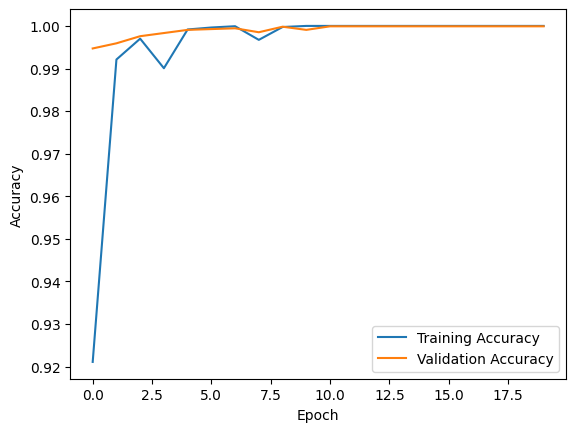

In [ ]:
# 각 epoch별 accuracy 그래프 그리기
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 손실 그래프 그리기
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

overfitting 됬다고 판단된다. regularization layer(Drop out)추가해본다.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 클래스 개수
num_classes = 9

# 모델 정의
model_regular = models.Sequential()

# 첫 번째 합성곱 층
model_regular.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(26, 26, 3)))

# 두 번째 합성곱 층
model_regular.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_regular.add(layers.MaxPooling2D((1, 1)))

# 세 번째 합성곱 층
model_regular.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_regular.add(layers.MaxPooling2D((2, 2)))

model_regular.add(layers.Conv2D(192, (3, 3), activation='relu', padding='same'))

# 완전 연결 층
model_regular.add(layers.Flatten())
model_regular.add(layers.Dense(192, activation='relu'))

#drop out 층 추가
model_regular.add(layers.Dropout(0.5))

# 출력 층
model_regular.add(layers.Dense(num_classes, activation='softmax'))

# 모델 컴파일
model_regular.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 구조 출력
model_regular.summary()





Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 conv2d_21 (Conv2D)          (None, 26, 26, 64)        9280      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 13, 13, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 13, 13, 192)      

In [ ]:
history = model_regular.fit(X_train, y_train, epochs=20, batch_size=160, validation_split=0.2)

Epoch 1/20
270/270 [==============================] - 11s 33ms/step - loss: 0.3496 - accuracy: 0.8740 - val_loss: 0.2230 - val_accuracy: 0.9340
Epoch 2/20
270/270 [==============================] - 10s 37ms/step - loss: 0.0518 - accuracy: 0.9833 - val_loss: 0.0078 - val_accuracy: 0.9972
Epoch 3/20
270/270 [==============================] - 9s 32ms/step - loss: 0.0273 - accuracy: 0.9910 - val_loss: 0.0027 - val_accuracy: 0.9993
Epoch 4/20
270/270 [==============================] - 9s 35ms/step - loss: 0.0181 - accuracy: 0.9943 - val_loss: 0.0035 - val_accuracy: 0.9991
Epoch 5/20
270/270 [==============================] - 9s 31ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.0029 - val_accuracy: 0.9991
Epoch 6/20
270/270 [==============================] - 9s 32ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 7/20
270/270 [==============================] - 8s 31ms/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.0012 - val_accuracy: 0.99

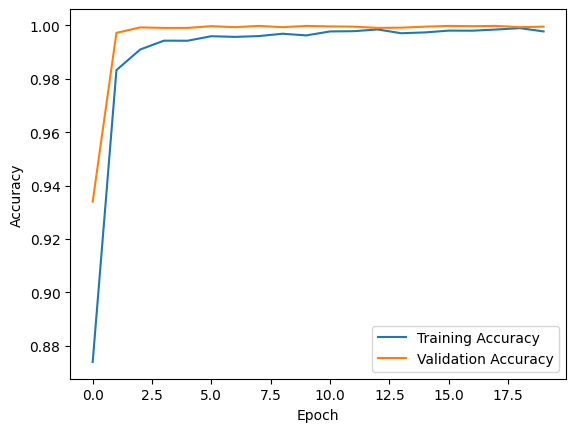

In [ ]:
# 각 epoch별 accuracy 그래프 그리기
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 최종 결과

In [ ]:
# 모델 평가 (테스트 데이터 사용)
test_loss, test_accuracy = model_regular.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

250/250 [==============================] - 1s 4ms/step - loss: 0.4221 - accuracy: 0.9611
Test Accuracy: 96.11%
